# Delaunay triangulation

One beautiful pattern to fill a surface is filling with a [Voronoï diagram](https://en.wikipedia.org/wiki/Voronoi_diagram).

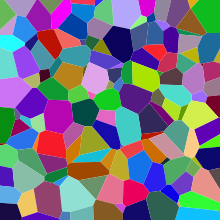

Unfortunately, Onshape does not appear to have anything that allows to generate a voronoï diagram. And that's why I'll try to write a FeatureScript to do that.

After some searches, it appears that
- There is no "easy" way to generate a Voronoï diagram
- Generating a Voronoï diagram is often implemented with it's dual operation, that is, generating a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) of a set of points.
- There is a rather great blogpost that breaks down an implementation of the Delaunay triangulation: https://ianthehenry.com/posts/delaunay/

So here goes myself, following the blog post, and converting the code to Onshape's Feature script ... until I find out that some important parts have been left out.

Being not so well acquainted with Feature script, and given the clumsyness of iterating with it, I decide to make a first implementation im Python, so that I can get a good grasp of the various untold parts, and then make a Feature script implementation.

# Blog post: given code

The first step is to extract the code given in the blog post, and convert it to Python (from javascript).

## QuarterEdge

Let's first implement the QuarterEdge structure. As explained in the blog post, QuarterEdge are oriented edges between two vertices, except their representation is not straightforward:

A QuarterEdge is a data structure made of

- the origin vertex of the edge they represent (in the `origin` field, named `data` in the blog post - this is a very bad name IMO).
- the next edge starting from origin (clockwise)
- finally, a field named `rot`, that points to the dual of the edge (whose origin is the *leftward* face when drawing the graph).

See the blog post for additional explanation, and very nice interactive diagrams.

Note that the "dual" QuarterEdges do not have anything in the `origin` field - it may have been better to use a different structure for them.

In [1]:
from typing import NamedTuple
from dataclasses import dataclass

class Point(NamedTuple):
    """Points are immutable, so using a NamedTuple is particularly appopriate"""
    x: int
    y: int

    def __repr__(self):
        return f"({self.x}, {self.y})"

        
@dataclass
class QuarterEdge:
    """
    A quarter edge 
    origin: starting point of this edge
    next: next edge starting from origin
    rot: dual edge
    """
    origin: Point | None
    next: "QuarterEdge"
    rot: "QuarterEdge"
    color: str = "blue"

    @property
    def sym(self) -> "QuarterEdge":
        """Reverse direction"""
        return self.rot.rot

    @property
    def tor(self) -> "QuarterEdge":
        return self.rot.rot.rot

    @property
    def prev(self) -> "QuarterEdge":
        """Previous edge starting from data"""
        return self.rot.next.rot
        
    @property
    def lnext(self) -> "QuarterEdge":
        """next edge in triangle (keeping same orientation"""
        return self.tor.next.rot
        
    @property
    def dest(self) -> Point:
        """End point of the edge"""
        return self.sym.origin

    def __repr__(self):
        return f"{self.origin} -> {self.dest}"

    def id(self):
        """Returns a frozenset containing both vertices"""
        if self.origin is None:
            raise ValueError("Dual QuarterEdge in dual does not have coords")
        return frozenset( [self.origin, self.dest] )

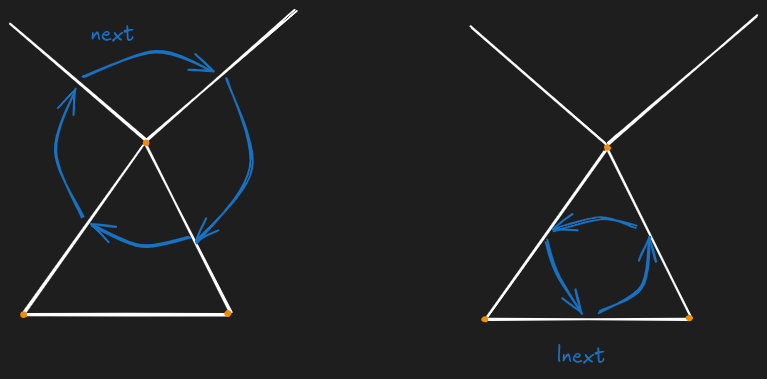

In [2]:
def makeQuadEdge(start: Point, end: Point):
    """Creates an edge from start to end:
    Creates an oriented edge, it's symmetrical, and the two dual edges"""
    startEnd = QuarterEdge(origin=None, next=None, rot=None)
    leftRight = QuarterEdge(origin=None, next=None, rot=None)
    endStart = QuarterEdge(origin=None, next=None, rot=None)
    rightLeft = QuarterEdge(origin=None, next=None, rot=None)
    
    startEnd.origin = start
    endStart.origin = end
    
    startEnd.rot = leftRight
    leftRight.rot = endStart
    endStart.rot = rightLeft
    rightLeft.rot = startEnd
    
    # normal edges are on different vertices,
    # and initially they are the only edges out
    # of each vertex
    startEnd.next = startEnd
    endStart.next = endStart
    
    # but dual edges share the same face, 
    # so they point to one another
    leftRight.next = rightLeft
    rightLeft.next = leftRight
    
    return startEnd

In [3]:
def swapNexts(a: QuarterEdge, b: QuarterEdge):
  a.next, b.next = b.next, a.next

def splice(a: QuarterEdge, b: QuarterEdge):
    """Inserts an edge at a given point"""
    swapNexts(a.next.rot, b.next.rot)
    swapNexts(a, b)


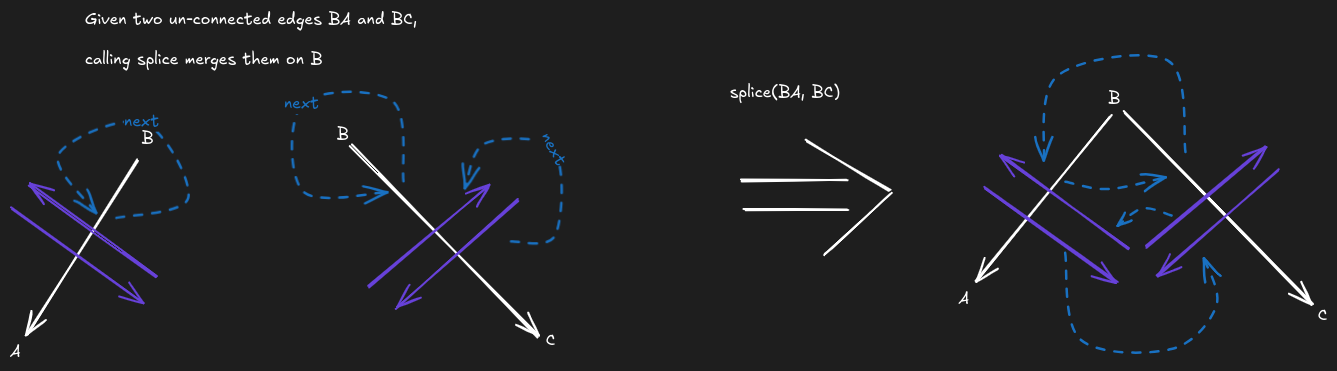

In [4]:
def makeTriangle(a: Point, b: Point, c: Point):
  ab = makeQuadEdge(a, b)
  bc = makeQuadEdge(b, c)
  ca = makeQuadEdge(c, a)

  splice(ab.sym, bc)
  splice(bc.sym, ca)
  splice(ca.sym, ab)

  return ab
    

Fully connected triangle:

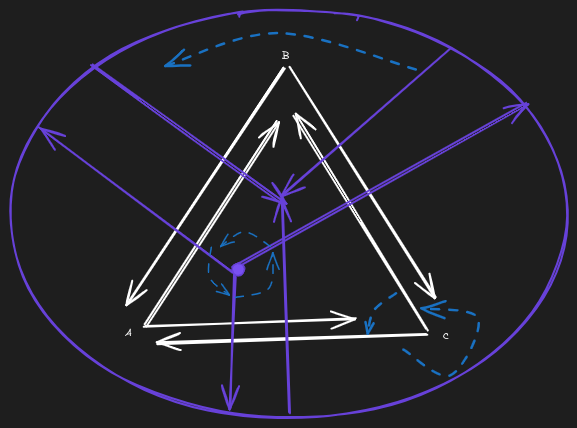

In [5]:
def connect(a: QuarterEdge, b: QuarterEdge): 
    """Creates a new edge between  two points"""
    newEdge = makeQuadEdge(a.dest, b.origin)
    splice(newEdge, a.lnext)
    splice(newEdge.sym, b)
    return newEdge


def sever(edge: QuarterEdge): 
    splice(edge, edge.prev)
    splice(edge.sym, edge.sym.prev)

def insertPoint(polygonEdge: QuarterEdge, point: Point): 
    firstSpoke = makeQuadEdge(polygonEdge.origin, point)
    splice(firstSpoke, polygonEdge)
    spoke = firstSpoke
    while True:
        spoke = connect(polygonEdge, spoke.sym)
        spoke.rot.origin = None
        spoke.tor.origin = None
        polygonEdge = spoke.prev
        if (polygonEdge.lnext == firstSpoke):
            break
    return firstSpoke

def flip(edge: QuarterEdge): 
    a = edge.prev
    b = edge.sym.prev
    splice(edge, a)
    splice(edge.sym, b)
    splice(edge, a.lnext)
    splice(edge.sym, b.lnext)
    edge.origin = a.dest
    # edge.dest = b.dest - but cannot set dest
    edge.sym.origin = b.dest
    
    return edge

# Drawing the graph

## Drawing a single triangle

In [6]:
from ipycanvas import Canvas
import numpy as np
import random


WIDTH = 500
HEIGHT = 300
canvas = Canvas(width=WIDTH, height=HEIGHT)
 

def draw_edge(canvas, edge):
    canvas.stroke_style = edge.color
    canvas.stroke_line(edge.origin.x, edge.origin.y, edge.dest.x, edge.dest.y)
    canvas.stroke_style = "red"
    start_x = edge.dest.x - (edge.dest.x - edge.origin.x) / 10
    start_y = edge.dest.y - (edge.dest.y - edge.origin.y) / 10
    canvas.stroke_line(start_x, start_y, edge.dest.x, edge.dest.y)
    canvas.fill_text(str(edge.origin), edge.origin.x, edge.origin.y)
    canvas.fill_text(str(edge.dest), edge.dest.x, edge.dest.y)

points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)
draw_edge(canvas, triangle)
draw_edge(canvas, triangle.lnext)
draw_edge(canvas, triangle.lnext.lnext)
canvas

Canvas(height=300, width=500)

In [7]:
triangle, triangle.next

((10, 10) -> (200, 300), (10, 10) -> (400, 10))

In [8]:
triangle.lnext

(200, 300) -> (400, 10)

In [9]:
triangle.lnext.lnext

(400, 10) -> (10, 10)

## Walking the graph to draw all the edges

In [10]:
def walk(edge: QuarterEdge):
    walked = set()
    to_walk = {edge.id(): edge}
    while len(to_walk) > 0:
        edge_id, edge = to_walk.popitem()
        yield edge
        walked.add(edge_id)
        
        if not edge.lnext.id() in walked | to_walk.keys():
            to_walk[edge.lnext.id()] = edge.lnext

        neighbour = edge.next
        while True:
            if not neighbour.id() in walked | to_walk.keys():
                to_walk[neighbour.id()] = neighbour
            neighbour = neighbour.next
            if neighbour.id() == edge.id():
                break

In [11]:
def draw_all_edges(canvas, start_edge: QuarterEdge):
    for edge in walk(start_edge):
        # print("Walking", edge)
        draw_edge(canvas, edge)

In [12]:
points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)

insertPoint(triangle, Point(100, 100))
canvas = Canvas(width=WIDTH, height=HEIGHT)
draw_all_edges(canvas, triangle)
canvas

Canvas(height=300, width=500)


```{pyodide-python}
points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)

insertPoint(triangle, Point(100, 100))
canvas = Canvas(width=WIDTH, height=HEIGHT)
draw_all_edges(canvas, triangle)
canvas
```

In [13]:
triangle.next.lnext.next.next

(100, 100) -> (200, 300)

# Finding the face to insert a new point

In [14]:
class Stack:
    def __init__(self, current):
        self.current = current
        self.p = None
        self.pp = None
        self.ppp = None

    def push(self, value):
        self.ppp = self.pp
        self.pp = self.p
        self.p = self.current
        self.current = value

In [15]:
def orientation(t1: Point, t2: Point, t3: Point):
    u_x = t2.x - t1.x
    u_y = t2.y - t1.y
    v_x = t3.x - t1.x
    v_y = t3.y - t1.y
    return u_x * v_y - u_y * v_x

In [16]:
class Stack:
    def __init__(self):
        self.a = None
        self.b = None
        self.c = None
    
    def push(self, value):
        self.c = self.b
        self.b = self.a
        self.a = value

    def values(self):
        return {self.a, self.b, self.c}


def find_containing_triangle(edge: QuarterEdge, point: Point):
    """Walks the graph until a triangle containing the point is found
    Point on edge is not handled yet
    """
    stack = Stack()
    current = edge
    visited = set()
    while True:
        
        if stack.values() ==  {"l"}:
            return current
        if stack.values() == {"r"}:
            return current.sym
        
        if id(current) in visited:
            raise Exception("Out of bounding triangle")
        visited.add(id(current))
        if orientation(current.origin, current.dest, point) < 0:
            # print(f"On left {current}")
            stack.push("l")
            current = current.lnext
        else:
            # print(f"On right {current}")
            stack.push("r")
            current = current.rot.rot.next

In [17]:
points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)
find_containing_triangle(triangle, Point(100, 100))

(10, 10) -> (200, 300)

In [18]:
from ipywidgets import Output 
out = Output()
canvas = Canvas(width=WIDTH, height=HEIGHT)

points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)
insertPoint(triangle, Point(200, 150))

draw_all_edges(canvas, triangle)

@out.capture()
def add_point(x, y):
    point = Point(int(x), int(y))    
    print("Mouse down event:", point)
    insert_loc = find_containing_triangle(triangle, point)
    insertPoint(insert_loc, point)
    canvas.clear()
    draw_all_edges(canvas, triangle)
    
@out.capture()
def show_get_side(x, y):
    print("Mouse down event:", x, y)
    point = Point(int(x), int(y))
    print(get_side(triangle, point))

canvas.on_mouse_down(add_point)
# canvas.on_mouse_down(show_get_side)
canvas

Canvas(height=300, width=500)

In [19]:
out

Output()

In [20]:
out

Output()

# Flipping edges

In [21]:
def orientation(t1: Point, t2: Point, t3: Point):
    u_x = t2.x - t1.x
    u_y = t2.y - t1.y
    v_x = t3.x - t1.x
    v_y = t3.y - t1.y
    return u_x * v_y - u_y * v_x

In [22]:
def point_in_circle(
    t1: Point, t2: Point, t3: Point, a: Point
):
    if not orientation( t1, t2, t3) > 0:
        t2, t3 = t3, t2
    make_row = lambda p: [ p.x, p.y, p.x*p.x + p.y*p.y, 1]
    return np.linalg.det(np.array([
        make_row(t1), 
        make_row(t2), 
        make_row(t3), 
        make_row(a)
    ])) > 0

In [23]:
def check_edge(edge: QuarterEdge, outer_edge_ids: set):
    orig = edge.origin
    end = edge.dest
    left_third = edge.next.dest
    right_third = edge.prev.dest
    print(f"Checking {edge}: left {left_third} right {right_third}")
    if point_in_circle(orig, end, left_third, right_third):
        if edge.id() in outer_edge_ids:
            print(f"Warning: {edge.id()} in outer_edge_ids")
            return edge.sym.next.next
        flipped = flip(edge)
        flipped.color="yellow"
        return flipped.sym.next
    return edge.sym.next.next

def check_edges(edge: QuarterEdge, outer_edge_ids: set):
    already_checked = set()
    to_check = [ edge ]
    while to_check:
        edge = to_check.pop()
        to_check_new = check_edge(edge, outer_edge_ids)
        already_checked.add(edge.id())
        if to_check_new.id() not in already_checked:
            to_check.append(to_check_new)
        
def insert_delaunay(edge: QuarterEdge, point: Point, outer_edge_ids: set):
    insert_loc = find_containing_triangle(triangle, point)
    spoke = insertPoint(insert_loc, point)
    spoke.color = "green"
    check_edges(spoke.next, outer_edge_ids)
    return spoke

In [24]:
from ipywidgets import Output 
out = Output()
canvas = Canvas(width=WIDTH, height=HEIGHT)

points = [
    Point(0, 300), 
    Point(400, 300),
    Point(200, 10)
]
triangle = makeTriangle(*points)
outer_edge_ids = [
    triangle.id(), triangle.next.id(), triangle.next.sym.next.id(),
]


draw_all_edges(canvas, triangle)


@out.capture()
def add_point(x, y):
    point = Point(int(x), int(y))    
    print("Mouse down event:", point)
    spoke = insert_delaunay(triangle, point, outer_edge_ids)
    canvas.clear()
    draw_all_edges(canvas, triangle)
    draw_edge(canvas, spoke)
    
@out.capture()
def show_get_side(x, y):
    print("Mouse down event:", x, y)
    point = Point(int(x), int(y))
    print(get_side(triangle, point))

canvas.on_mouse_down(add_point)
# canvas.on_mouse_down(show_get_side)
canvas

Canvas(height=300, width=500)

In [25]:
out

Output()